# ロボットアーム - Panda Gym

In [1]:
import numpy as np
import gymnasium as gym
import panda_gym
import matplotlib.pyplot as plt
from matplotlib import font_manager
from tqdm import tqdm

import torch

from td3_algo import TD3Trainer

# 日本語フォント設定（japanize_matplotlibで文字化け防止）
import matplotlib
try:
    import japanize_matplotlib  # noqa: F401
except ImportError:
    print("japanize_matplotlib が見つかりません。必要に応じて `pip install japanize_matplotlib` を実行してください。")

# マイナス記号を正しく表示
matplotlib.rcParams['axes.unicode_minus'] = False

* ロボット: Franka Emika Panda マニピュレータの操作タスクをシミュレート。
<br>

* 観測空間:
    - すべてのタスクにグリッパの位置と速度（6値）。
    - 物体を扱うタスクでは位置・姿勢・線形/回転速度が追加（物体1つにつき12値）。
    - グリッパ開閉距離（拘束されていなければ1値）。

* 行動空間:
    - グリッパの平行移動コマンド（x, y, z の3値）。
    - グリッパ開閉コマンド（1値）。
    
* シミュレーション:
    - エージェントの1ステップあたり20タイムステップ（各2ms）。
    - インタラクション周波数は25Hz。
    - ほとんどのタスクは約2秒（50ステップ）のエピソード長。
    
* 報酬関数:
    - 既定の報酬はスパース: 目標到達（5cm 以内）なら0、それ以外は -1。
    - スパース報酬は定義が簡単だが、進捗の手掛かりが少ない。

# PandaReach-v3

* ターゲット位置は30cm × 30cm × 30cmの範囲でランダム生成され、グリッパがそこへ到達するタスク。

In [2]:
env = gym.make(
    "PandaReach-v3",
    render_mode="rgb_array",
    renderer="OpenGL",
    render_target_position=[0, 0.15, 0.25],
    render_distance=0.85,
    render_yaw=135,
    render_pitch=-20,
)

pybullet build time: Dec  5 2025 16:32:26


argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=5
argv[0] = --unused
argv[1] = --background_color_red=0.8745098114013672
argv[2] = --background_color_green=0.21176470816135406
argv[3] = --background_color_blue=0.1764705926179886
argv[4] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Mesa
GL_RENDERER=llvmpipe (LLVM 20.1.2, 256 bits)
GL_VERSION=4.5 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.2
GL_SHADING_LANGUAGE_VERSION=4.50
pthread_getconcurrency()=0
Version = 4.5 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.2
Vendor = Mesa
Renderer = llvmpipe (LLVM 20.1.2, 256 bits)
b3Print


観測空間: Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))

行動空間:  Box(-1.0, 1.0, (3,), float32)

初期状態:  ({'observation': array([ 3.8439669e-02, -2.1944723e-12,  1.9740014e-01,  0.0000000e+00,
       -0.0000000e+00,  0.0000000e+00], dtype=float32), 'achieved_goal': array([ 3.8439669e-02, -2.1944723e-12,  1.9740014e-01], dtype=float32), 'desired_goal': array([0.08857898, 0.09645446, 0.03886046], dtype=float32)}, {'is_success': array(False)})

環境での1ステップ:  ({'observation': array([ 0.01701545,  0.02366417,  0.19525036, -0.26040578,  0.9987153 ,
        0.05004497], dtype=float32), 'achieved_goal': array([0.01701545, 0.02366417, 0.19525036], dtype=float32), 'desired_goal': array([0.08857898, 0.09645446, 0.03886046], dtype=float32)}, -1.0, False, False, {'is_success': False})


レンダリングした環境: 


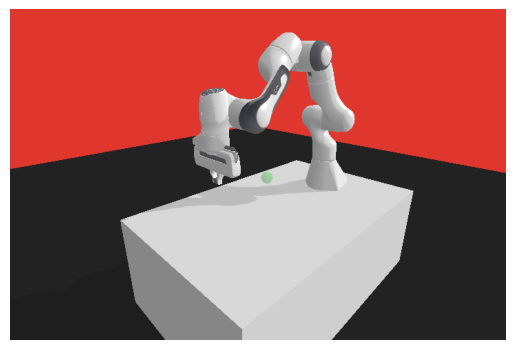

In [3]:
print('\n観測空間:', env.observation_space)
print('\n行動空間: ', env.action_space)
print('\n初期状態: ', env.reset())

# アクションは環境の期待する形状に合わせてサンプルする
sample_action = env.action_space.sample()
print('\n環境での1ステップ: ', env.step(sample_action))

print('\n\nレンダリングした環境: ')
env.reset()
plt.axis('off')
plt.imshow(env.render())
plt.show()

In [4]:
obs_shape = env.observation_space['observation'].shape[0] + \
            env.observation_space['achieved_goal'].shape[0] + \
            env.observation_space['desired_goal'].shape[0]

# 学習 - エキスパートポリシー取得

1. **初期化**:
   - ハイパーパラメータとアクター/クリティックを初期化。
   - リプレイバッファを初期化。

2. **学習ループ**:
   - エピソードを所定回数だけ繰り返す。
     - 環境をリセットして初期観測を得る。
     - エピソードが終了するまで:
       - アクター + 探索ノイズで行動を選択。
       - 行動を実行し、次状態と報酬を取得。
       - 経験 (s, a, r, s', done) をリプレイバッファへ保存。
       - HER でバッファを拡張。
       - バッファからサンプルしたミニバッチでクリティックを最適化。
       - 2回に1回の頻度でアクターを更新。
       - ターゲットアクター/クリティックをソフトアップデート。

3. **HER 拡張**:
   - 未来の状態をゴールとして再利用し、追加の学習サンプルを生成。

4. **モデル最適化**:
   - バッファに十分なサンプルがある場合にミニバッチをサンプル。
   - 2つのクリティックでターゲットQを計算し、損失を最小化。
   - クリティック2回更新につき1回アクターを更新。

5. **2つのクリティックを使う意義**:
   - min(Q1, Q2) を用いることで過大評価バイアスを抑制し、学習を安定化。
   - 2系統により過学習を抑え、局所解へのはまり込みを回避しやすくする。

In [5]:
expert = TD3Trainer(env=env, input_dims=obs_shape, agent_name='Expert', model_save_path='./Models/Expert/', 
                    exploration_period=300)

Training..:   1%|          | 6/500 [00:01<01:37,  5.05it/s]/home/shimoiyusuke/manipulator-inverse-rl/TD3/td3_algo.py:135: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state = torch.tensor([observation], dtype=torch.float32).to(self.device)
/home/shimoiyusuke/manipulator-inverse-rl/TD3/td3_algo.py:135: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state = torch.tensor([observation], dtype=torch.float32).to(self.device)
Training..:  20%|██        | 102/500 [00:19<00:46,  8.48it/s]

Episode: 100 	 Steps: 3 	 Score: -2.0 	 Average score: -35.3 	 Success: 1 	 Avg success: 0.35


Training..:  41%|████      | 203/500 [00:29<00:25, 11.70it/s]

Episode: 200 	 Steps: 3 	 Score: -2.0 	 Average score: -8.7 	 Success: 1 	 Avg success: 0.92


Training..:  61%|██████    | 303/500 [00:38<00:17, 11.18it/s]

Episode: 300 	 Steps: 4 	 Score: -3.0 	 Average score: -2.0 	 Success: 1 	 Avg success: 1.00


Training..:  81%|████████  | 403/500 [00:47<00:08, 10.98it/s]

Episode: 400 	 Steps: 4 	 Score: -3.0 	 Average score: -2.0 	 Success: 1 	 Avg success: 1.00


Training..: 100%|██████████| 500/500 [00:55<00:00,  8.93it/s]



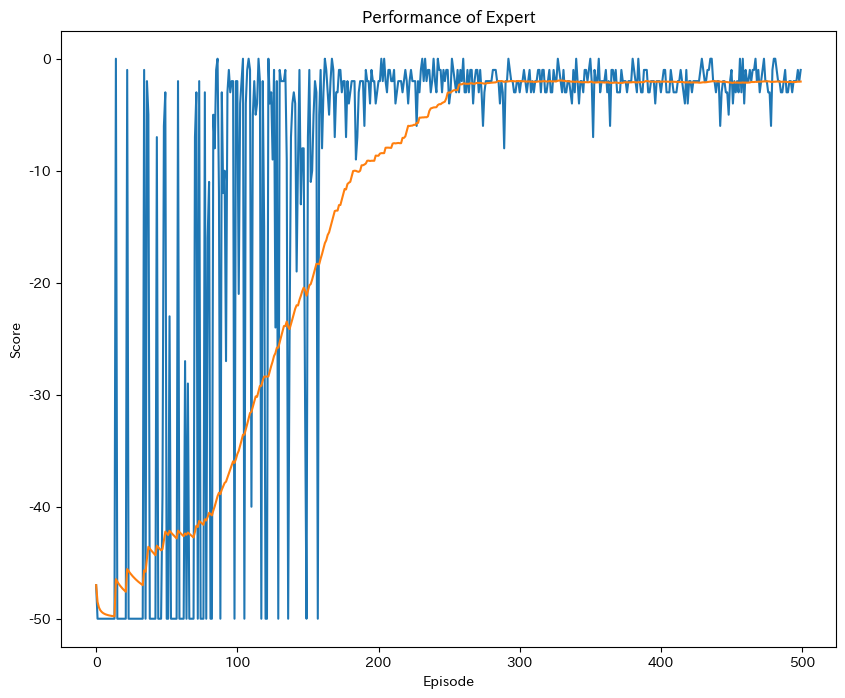

In [6]:
score_history, avg_score_history, success_history, avg_success_history = expert.td3_train(
    n_episodes=500,
    opt_steps=10,
    print_every=100,
    plot_save_path='../Results/TD3/Expert Performance.png'
)

In [7]:
expert.save_model()

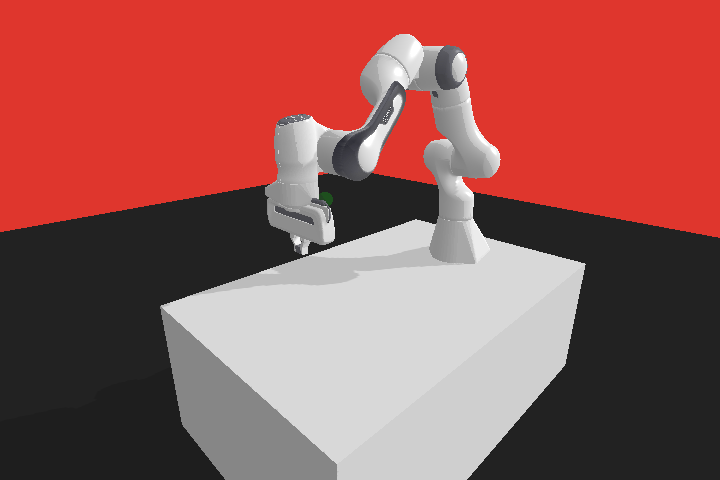

エキスパートの報酬: -2.000 - タスク: 成功


In [8]:
expert_reward, success = expert.test_model(env=env, steps=100, render_save_path='../Results/TD3/Expert Policy', fps=5)
success_str = "成功" if success else "失敗"
print(f'エキスパートの報酬: {expert_reward:.3f} - タスク: {success_str}')

In [9]:
# 学習直後の軽量評価（平均報酬と成功率）
returns, successes = [], []
for _ in range(10):
    ep_ret, success = expert.test_model(env=env, steps=200, render_save_path=None)
    returns.append(ep_ret)
    successes.append(1 if success else 0)
mean_r = float(np.mean(returns))
succ = float(np.mean(successes) * 100)
print(f"TD3 Expert 直後評価: 平均報酬 {mean_r:.3f}, 成功率 {succ:.1f}%")

TD3 Expert 直後評価: 平均報酬 -2.200, 成功率 100.0%


# IRLアルゴリズム

* 新規エージェントの学習では環境の既定報酬ではなく、IRLで推定したエキスパートの報酬関数を用いる。報酬は重み $w$ と観測特徴 $\Phi(s)$ によって与えられる。
* 特徴期待値 ($\mu(\pi)$): ポリシー $\pi$ に従うときの長期的な特徴ベクトルの期待値。
* エキスパートの特徴期待値 $\mu_E$ をモンテカルロ軌跡から推定できる。
* サンプル数 $m$ 本のエキスパート軌跡から得られる $\mu_E$ の経験的推定は次式:

$$\hat{\mu}_E = \frac{1}{m} \sum_{i=1}^m \sum_{t=0}^T \gamma^t \cdot \phi(\hat{s}^{(i)}_t)$$

In [10]:
expert = TD3Trainer(env=env, input_dims=obs_shape, agent_name='Expert', model_load_path='./Models/Expert/')

In [11]:
def compute_average_feature(agent, m=2000):
        """
        m エピソードにわたって平均特徴ベクトル（特徴期待値）と平均報酬を計算する。
        """
        with torch.inference_mode():
            feature_sum, reward_sum = None, None

            for i in tqdm(range(m), desc='特徴ベクトルと報酬を計算中'):
                reward, success, states = agent.test_model(steps=1000, save_states=True)

                # エピソード全体の特徴ベクトルの平均
                episode_mean = torch.stack(states).mean(0)

                if feature_sum is None:
                    feature_sum, reward_sum = episode_mean, reward
                else:
                    feature_sum += episode_mean
                    reward_sum += reward

            # μ̂_E = (1/m) Σ_m Σ_t (γ^t φ(ŝ^(i)_t)) （γ ≈ 1 を仮定）
            feature_sum /= m
            reward_sum /= m

            print('\n特徴期待値: ',feature_sum)
            print('\n平均報酬: ',reward_sum)

        return feature_sum, reward_sum

In [12]:
expert_feature_expectation, expert_mean_reward = compute_average_feature(expert, m=1000)   # μ_E

特徴ベクトルと報酬を計算中:   0%|          | 0/1000 [00:00<?, ?it/s]

特徴ベクトルと報酬を計算中: 100%|██████████| 1000/1000 [00:28<00:00, 35.58it/s]


特徴期待値:  tensor([[ 2.1978e-02, -1.2132e-03,  1.7500e-01, -2.0396e-01, -1.6377e-02,
         -2.7371e-01,  2.1978e-02, -1.2132e-03,  1.7500e-01,  1.1472e-04,
          2.6261e-04,  1.5212e-01]], device='cuda:0')

平均報酬:  -1.854


## 射影法によるIRLアルゴリズム

1. **初期化:**
   - 初期ポリシー $\pi^{(0)}$ をランダムに選ぶ。
   - モンテカルロなどで特徴期待値 $\mu^{(0)}$ を計算。
   - 反復カウンタ $i = 1$ に設定。

2. **マージン計算:**
   - 現在の特徴期待値と過去ポリシー群との最大マージン $t^{(i)}$ を計算。
   - 射影法で最適な重み $w^{(i)}$ を求める。

3. **終了判定:**
   - マージン $t^{(i)} \leq \epsilon$ なら終了。

4. **IRL学習:**
   - 重み $w^{(i)}$ による報酬でMDPを定義し、RLアルゴリズムで最適ポリシー $\pi^{(i)}$ を計算。

5. **特徴期待値の更新:**
   - 新ポリシー $\pi^{(i)}$ の特徴期待値 $\mu^{(i)}$ を推定。

6. **反復更新:**
   - 反復カウンタ $i$ をインクリメント。

7. **繰り返し:**
   - 手順2へ戻り、終了条件を満たすまで繰り返す。

終了後、$\{\pi^{(i)} : i = 0, \ldots, n\}$ のポリシー列がエキスパート挙動を近似する。

In [13]:
def projection_method_algorithm(env, epsilon=0.001, m=2000, n_episodes=100,
                                opt_steps=10, exploration_period=100, save_render=True, fps=5):
    """
    Run a fixed number of projection-method IRL iterations without user prompts.

    Trains up to 10 apprentice agents, tracks rewards, margins, and success rates.

    Success now relies on env info['is_success'] collected inside TD3.
    """

    max_runs = 10  # total apprentice agents to train automatically
    feature_expectation = []
    feature_expectation_bar = []
    weights = []
    margins = []
    rewards = []
    success_rates = []  # success rate (%) per apprentice
    obs_shape = (env.observation_space['observation'].shape[0] +
                 env.observation_space['achieved_goal'].shape[0] +
                 env.observation_space['desired_goal'].shape[0])
        # Step 1: initialization for the very first apprentice

        if i == 0:

            observation, info = env.reset()

            current_observation, current_achieved_goal, current_desired_goal = observation.values()

            state = np.concatenate((current_observation, current_achieved_goal, current_desired_goal))

            sample_feature = torch.tensor(state, dtype=torch.float32)



            w_0 = torch.randn(sample_feature.size(0), 1).div_(torch.randn(1).norm())

            weights.append(w_0)

            _, _, _, _ = apprentice.td3_train(n_episodes=n_episodes, opt_steps=opt_steps, \

                                 reward_weights=w_0, print_every=n_episodes+1, \

                                 plot_save_path=f'../Results/TD3/Apprentice_{i} Performance.png')



            apprentice_feature_expectation, apprentice_reward = compute_average_feature(agent=apprentice, m=m)

            rewards.append(apprentice_reward)

            margins.append(1)  # baseline margin placeholder for first iteration

            feature_expectation.append(apprentice_feature_expectation)



        else:

            # Step 2: IRL weight update using projection method

            if i == 1:

                feature_expectation_bar.append(feature_expectation[i - 1])       # μ̄^(0) = μ^(0)

                weights.append((expert_feature_expectation - feature_expectation[i - 1]).view(-1, 1))   # w^(1) = μ_E - μ^(0)

                margins.append((expert_feature_expectation - feature_expectation_bar[i - 1]).norm().item())

                print("重み:", weights[i])

                print("マージン:", margins[i])

            else:

                A = feature_expectation_bar[i - 2]              # μ̄^(i-2)

                B = feature_expectation[i - 1] - A              # (μ^(i-1) - μ̄^(i-2))

                C = expert_feature_expectation - A              # μ_E - μ̄^(i-2)



                feature_expectation_bar.append(A + ((B.view(-1, 1).t() @ C.view(-1, 1)) / \

                                                    (B.view(-1, 1).t() @ B.view(-1, 1))) * B)  # projection step



                # w^(i) = μ_E - μ̄^(i-1)

                weight = (expert_feature_expectation - feature_expectation_bar[i - 1]).view(-1, 1)



                # t^(i) = ||μ_E - μ̄^(i-1)||_2

                margin = (expert_feature_expectation - feature_expectation_bar[i - 1]).norm().item()



                weights.append(weight)

                margins.append(margin)



                print("マージン:", margins[i])

                print("重み:", weights[i])



            # Step 3: early stop if the projection margin is sufficiently small

            if margins[i] <= epsilon:

                print("Margin below epsilon; stopping iterations early.")

                break



            # Step 4: RL training with updated IRL reward weights

            _, _, _, _ = apprentice.td3_train(n_episodes=n_episodes, opt_steps=opt_steps, \

                                 reward_weights=weights[-1], print_every=n_episodes+1, \

                                 plot_save_path=f'../Results/TD3/Apprentice_{i} Performance.png')

            apprentice.save_model()



            # Evaluate current apprentice policy to compute success rate (using env is_success)

            eval_successes = []

            for _ in range(5):  # small evaluation batch to estimate success frequency

                _, success = apprentice.test_model(steps=500, render_save_path=None, fps=fps)

                eval_successes.append(1 if success else 0)

            success_rate = float(np.mean(eval_successes) * 100)

            success_rates.append(success_rate)

            print(f'Apprentice {i} success rate (5 eval episodes): {success_rate:.1f}%')



            if save_render:

                apprentice_reward, success = apprentice.test_model(steps=1000, render_save_path=f'../Results/TD3/Apprentice {i} Policy', fps=fps)

                success_str = "成功" if success else "失敗"

                print(f'{apprentice.agent_name} の報酬: {apprentice_reward:.3f} - タスク: {success_str}')



            # Step 5: Update feature expectation for the next iteration

            apprentice_feature_expectation, apprentice_reward = compute_average_feature(agent=apprentice, m=m)

            rewards.append(apprentice_reward)

            feature_expectation.append(apprentice_feature_expectation)



        # Ensure success rate list aligns with iterations (first run gets measured here)

        if i == 0:

            eval_successes = []

            for _ in range(5):

                _, success = apprentice.test_model(steps=500, render_save_path=None, fps=fps)

                eval_successes.append(1 if success else 0)

            success_rate = float(np.mean(eval_successes) * 100)

            success_rates.append(success_rate)

            print(f'Apprentice {i} success rate (5 eval episodes): {success_rate:.1f}%')



    return rewards, margins, success_rates

IndentationError: unexpected indent (2030581023.py, line 23)

In [ ]:
# Execute IRL projection method for a fixed 10 runs (auto) using env-provided success flags

rewards, margins, success_rates = projection_method_algorithm(env, n_episodes=400, m=500, exploration_period=100)



# Report aggregate success rate across all apprentices

overall_success_rate = float(np.mean(success_rates)) if success_rates else 0.0

print(f"Overall success rate across {len(success_rates)} apprentices: {overall_success_rate:.1f}%")

In [ ]:
# Plot apprentice rewards with 1-indexed horizontal axis

plt.figure(figsize=(8, 6))

plt.plot(range(1, len(rewards) + 1), rewards, marker='o')

plt.title('Average Episode Reward')

plt.xlabel('Apprentice Number')

plt.ylabel('Average Episode Reward')

plt.xticks(range(1, len(rewards) + 1))  # force integer ticks starting at 1

plt.savefig("../Results/TD3/Apprentice Rewards.png")

plt.show()



# Plot success rates to visualize progression over apprentices

plt.figure(figsize=(8, 4))

plt.plot(range(1, len(success_rates) + 1), success_rates, marker='s', color='green')

plt.title('Apprentice Success Rate (Eval)')

plt.xlabel('Apprentice Number')

plt.ylabel('Success Rate (%)')

plt.ylim(0, 100)

plt.xticks(range(1, len(success_rates) + 1))

plt.grid(True, linestyle='--', alpha=0.4)

plt.savefig("../Results/TD3/Apprentice Success Rates.png")

plt.show()

In [ ]:
# L2 policy error plotted with 1-indexed x-axis and clear labels

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))



# Linear scale

axes[0].plot(range(1, len(margins) + 1), margins, label="$L_2$ Policy Error", marker='o')

axes[0].set_title("$L_2$ Policy Error")

axes[0].set_xlabel("Apprentice Number")

axes[0].set_ylabel("Squared Error of Features")

axes[0].set_xticks(range(1, len(margins) + 1))



# Log scale

axes[1].plot(range(1, len(margins) + 1), margins, label="$L_2$ Policy Error", marker='o')

axes[1].set_title("$L_2$ Policy Error (Log Scale)")

axes[1].set_xlabel("Apprentice Number")

axes[1].set_ylabel("Squared Error of Features")

axes[1].set_xticks(range(1, len(margins) + 1))

axes[1].set_yscale("log")



for ax in axes:

    ax.grid(True, linestyle='--', alpha=0.4)

    ax.legend()



plt.tight_layout()

plt.savefig("../Results/TD3/Apprentice Policy Error.png")

plt.show()

# 成功率による評価

`test_model()` が環境の `info['is_success']` を集計して返すようになったので、
累積報酬に閾値を設けずに成功率を評価できる。

In [ ]:
def evaluate_agent(agent, env, episodes=10, steps=200):
    """
    エージェントを複数エピソード実行して平均報酬と成功率を計算する。

    成功判定: 環境の info['is_success'] を test_model で集計した結果を利用する。
    """
    returns = []
    successes = []
    
    for _ in range(episodes):
        ep_ret, success = agent.test_model(env=env, steps=steps, render_save_path=None)
        returns.append(ep_ret)
        successes.append(1 if success else 0)
    
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    success_rate = np.mean(successes) * 100
    
    return mean_return, std_return, success_rate

# TD3 エキスパートを評価
expert_mean, expert_std, expert_sr = evaluate_agent(expert, env, episodes=10, steps=200)
print(f"TD3 Expert:")
print(f"  平均報酬: {expert_mean:.3f} ± {expert_std:.3f}")
print(f"  成功率: {expert_sr:.1f}%")